# 数据读取

In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

这段代码定义了一个名为 reduce_mem_usage 的函数，其目的是遍历数据框（DataFrame）的所有列，并根据列中数据的范围和类型，将数据类型转换为占用内存更小的类型，以此来减少数据框的内存使用。下面是对这段代码的详细解释和可能的一些改进点：

**代码解释

1、初始化内存使用量：首先，通过 df.memory_usage().sum() 计算并打印出原始数据框的内存使用量。
2、遍历列：接着，遍历数据框的每一列。
3、判断数据类型：
·如果列的数据类型不是 object（即不是字符串或混合类型），则进一步判断其是整数型还是浮点型。
·对于整数型列，根据列中的最小值和最大值选择合适的整数类型（int8, int16, int32, int64）。
·对于浮点型列，同样根据最小值和最大值选择合适的浮点类型（float16, float32, float64）。
·如果列的数据类型是 object，则将其转换为 category 类型，这通常用于处理字符串数据，可以显著减少内存使用，特别是当4、字符串数据中存在大量重复值时。
优化后的内存使用量：最后，计算并打印出优化后的内存使用量以及减少的百分比。

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520331.00 MB
Decreased by 73.4%


In [9]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

# 线性模型&五折交叉验证&模拟真实业务情况

In [10]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

## 简单建模

查看训练的线性回归模型的截距（intercept）与权重(coef)

In [11]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.341641865),
 ('v_8', 700675.560939819),
 ('v_9', 170630.27723214496),
 ('v_7', 32322.66193200012),
 ('v_12', 20473.670796984017),
 ('v_3', 17868.079541507966),
 ('v_11', 11474.938996723637),
 ('v_13', 11261.76456001776),
 ('v_10', 2683.9200905877838),
 ('gearbox', 881.8225039249874),
 ('fuelType', 363.90425072162213),
 ('bodyType', 189.602710120763),
 ('city', 44.94975120523052),
 ('power', 28.55390161675292),
 ('brand_price_median', 0.5103728134078624),
 ('brand_price_std', 0.4503634709263141),
 ('brand_amount', 0.1488112039506605),
 ('brand_price_max', 0.0031910186703131087),
 ('SaleID', 5.3559899198585607e-05),
 ('offerType', 5.67990355193615e-06),
 ('train', 2.60770320892334e-08),
 ('seller', -5.408655852079391e-07),
 ('brand_price_sum', -2.175006868187699e-05),
 ('name', -0.0002980012713096419),
 ('used_time', -0.0025158943328382425),
 ('brand_price_average', -0.4049048451010995),
 ('brand_price_min', -2.246775348690354),
 ('power_bin', -34.42064411725891),
 ('v_1

绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题

The predicted price is obvious different from true price


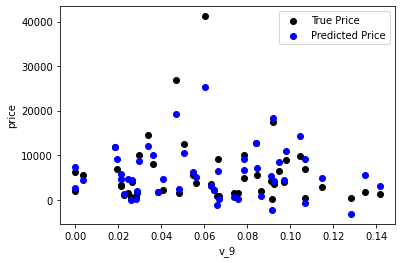

In [13]:
from matplotlib import pyplot as plt
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

通过作图我们发现数据的标签（price）呈现长尾分布，不利于我们的建模预测。原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。

It is clear to see the price shows a typical exponential distribution


<AxesSubplot:xlabel='price', ylabel='Density'>

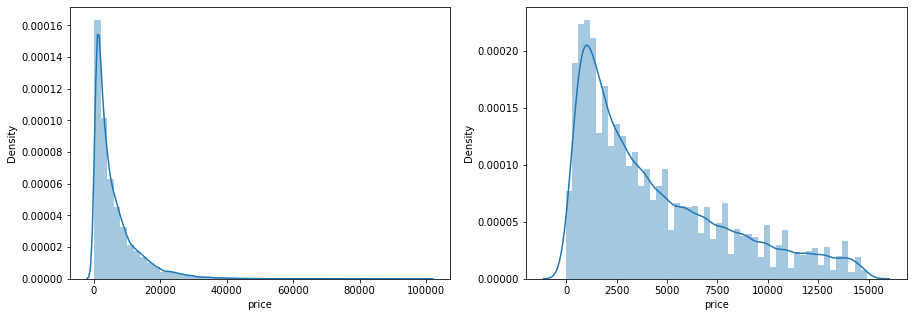

In [14]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution') #指数分布
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [16]:
train_y_ln = np.log(train_y + 1) #在这里我们对标签进行了 log(x+1) 变换，使标签贴近于正态分布

The transformed price seems like normal distribution


<AxesSubplot:xlabel='price', ylabel='Density'>

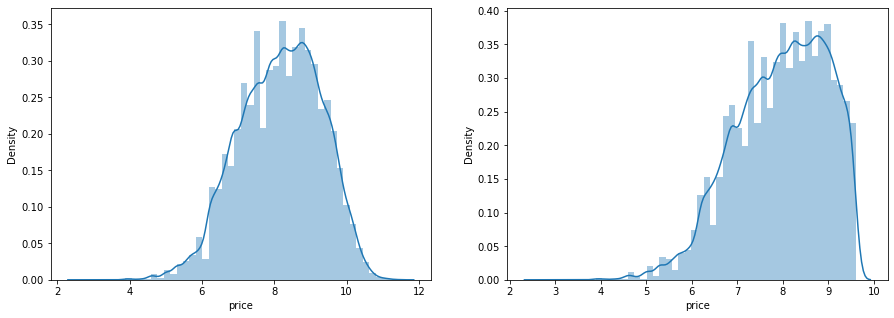

In [17]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [18]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.750745460078868


[('v_9', 8.052411927763881),
 ('v_5', 5.76424850228347),
 ('v_12', 1.6182066744724426),
 ('v_1', 1.4798302934424024),
 ('v_11', 1.166901449695523),
 ('v_13', 0.9404706038650743),
 ('v_7', 0.7137295307917485),
 ('v_3', 0.68378653203497),
 ('v_0', 0.008500525238681273),
 ('power_bin', 0.008497967226209413),
 ('gearbox', 0.007922377819943604),
 ('fuelType', 0.006684768278646313),
 ('bodyType', 0.004523520659140849),
 ('power', 0.0007161896117539618),
 ('brand_price_min', 3.3343530827510294e-05),
 ('brand_amount', 2.8978800102544486e-06),
 ('brand_price_median', 1.257111999662784e-06),
 ('brand_price_std', 6.659134278537051e-07),
 ('brand_price_max', 6.194957240892423e-07),
 ('brand_price_average', 5.99942948917174e-07),
 ('SaleID', 2.1194162066550644e-08),
 ('offerType', 2.8269653284951346e-10),
 ('seller', 1.5521095519943628e-10),
 ('train', -5.059064278611913e-12),
 ('brand_price_sum', -1.512651044581782e-10),
 ('name', -7.01551064992479e-08),
 ('used_time', -4.122477171060921e-06),
 ('

再次进行可视化，发现预测结果与真实值较为接近，且未出现异常状况

The predicted price seems normal after np.log transforming


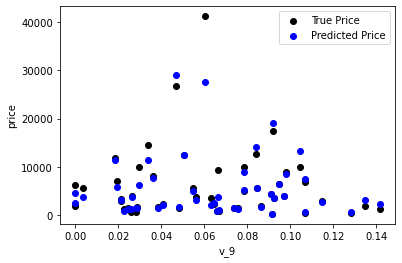

In [19]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

## 五折交叉验证

在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。

因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（Cross Validation）。

五折交叉验证（5-fold cross-validation）是一种评估机器学习模型性能的方法，它将数据集分成五个大小相等的子集（如果数据集大小不能被5整除，则可能需要稍微调整某些子集的大小以确保所有子集尽可能接近）。在五折交叉验证中，模型会被训练五次，每次都会使用四个子集作为训练集，剩下的一个子集作为验证集来评估模型的性能。这个过程会重复五次，每次使用不同的子集作为验证集，最终会得到五个性能评估结果。

以下是五折交叉验证的基本步骤：

1、划分数据集：将数据集随机划分为五个大小相等的子集（或尽可能相等）。

2、迭代训练与验证：

·在第一次迭代中，使用前四个子集作为训练集来训练模型，然后使用第五个子集作为验证集来评估模型的性能。

·在第二次迭代中，使用除了第二个子集之外的所有子集作为训练集，第二个子集作为验证集。

·这个过程重复五次，每次选择一个不同的子集作为验证集。

3、评估模型：收集所有五次迭代的性能评估结果（如准确率、召回率、F1分数、均方误差等），然后计算这些结果的平均值或中位数来作为模型性能的最终评估。

使用五折交叉验证的优点包括：

·减少过拟合风险：通过多次训练和验证，模型可以更加稳健地评估其泛化能力。

·减少随机性：由于数据集被多次划分和评估，最终的性能评估结果更有可能代表模型的真实性能。

·评估稳定性：如果模型在不同划分下的性能差异很大，这可能表明模型对数据的特定划分很敏感，需要进一步的调整或优化。

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


使用线性回归模型，对未处理标签的特征数据进行五折交叉验证（Error 1.36）

In [21]:
print('AVG:', np.mean(scores))

AVG: 1.3658024042408186


In [22]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


In [ ]:
使用线性回归模型，对处理过标签的特征数据进行五折交叉验证（Error 0.19）

In [23]:
print('AVG:', np.mean(scores))

AVG: 0.19325301535176873


In [24]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


## 模拟真实业务情况

但在事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大。

In [25]:
import datetime
sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)
model = model.fit(train_X, train_y_ln)
mean_absolute_error(val_y_ln, model.predict(val_X))

0.1957766704050737

## 绘制学习率曲线与验证曲线

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

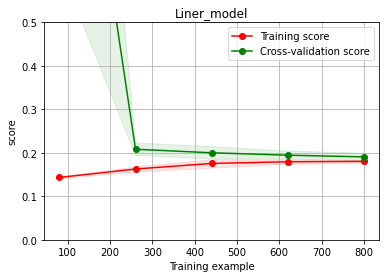

In [27]:
from sklearn.model_selection import learning_curve, validation_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

# 模型对比

In [28]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

## 线性模型&嵌入式特征选择

在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程有明显的分别。而嵌入式特征选择在学习器训练过程中自动地进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归与Lasso回归。

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
models = [LinearRegression(),
          Ridge(),
          Lasso()]
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


三种模型对比

In [30]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.750763371416923


<AxesSubplot:>

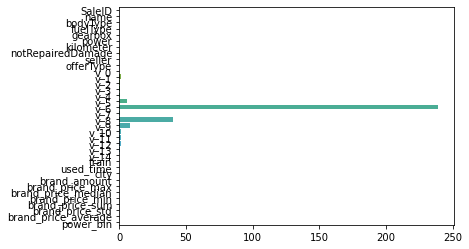

In [31]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』。

intercept:4.671710856961002


<AxesSubplot:>

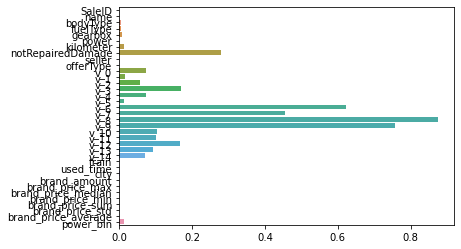

In [32]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现power与userd_time特征非常重要。

intercept:8.672182455497687


<AxesSubplot:>

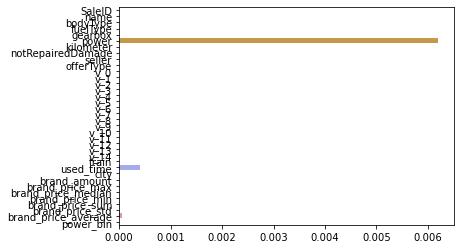

In [33]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)